In [7]:
import os
os.chdir("/Users/Mohammed/Desktop/SMALLMOL_MD")

In [127]:
import os
os.environ["PATH"] += ":/opt/homebrew/bin"

In [128]:
import os
import pandas as pd
from subprocess import run
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.analysis import distances
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdmolfiles import MolFromPDBFile

results = [] # Data storehouse

# 📥 Read SMALLMOL IDs from second column
csv_file = "SMALLMOL_SMILES_LIST.csv"
try:
    mol_df = pd.read_csv(csv_file, encoding="utf-8")
    cid_list = mol_df.iloc[:, 1].dropna().astype(str).tolist()
except FileNotFoundError:
    print("❌ ERROR: File 'SMALLMOL_SMILES_LIST.csv' not found!")
    exit()

def run_cmd(command, input_text="0", cwd=None):
    result = run(f"echo {input_text} | {command}", shell=True, cwd=cwd, capture_output=True, text=True)
    if result.returncode != 0:
        print("ERROR:")
        print(result.stderr)
    else:
        print("INFO:")
        print(result.stdout)

for cid in cid_list:
    base_dir = f"/Users/Mohammed/Desktop/SMALLMOL_MD/P{cid}"
    print(base_dir)

    if not os.path.exists(base_dir):
        print(f"⚠️  SMALLMOL {cid} directory not found, skipping...")
        continue

    
    for rep in range(1, 4):
        rep_dir = os.path.join(base_dir, f"md_rep{rep}")
        if not os.path.exists(rep_dir):
            print(f"⚠️  {rep_dir} not found, skipping...")
            continue

        xtc_path = os.path.join(rep_dir, "md_whole.xtc")
        tpr_path = os.path.join(rep_dir, "md.tpr")

        if os.path.exists(xtc_path):
            print(f"✅  md_whole.xtc already exists for P{cid} rep{rep}, skipping GROMACS post-processing...")
        else:
            print(f"\n📂 Processing P{cid} — md_rep{rep}...\n")

            # Step 1: Index creation
            run_cmd("gmx make_ndx -f md.tpr -o index.ndx", input_text="q", cwd=rep_dir)

            # Step 2: Remove PBC jumps
            run_cmd("gmx trjconv -s md.tpr -f md.trr -o md_nojump.xtc -pbc nojump", input_text="0", cwd=rep_dir)

            # Step 3: Center on UNL but keep all atoms
            run_cmd("gmx trjconv -s md.tpr -f md_nojump.xtc -o md_center.xtc -center -pbc mol", input_text="2 0", cwd=rep_dir)

            # Step 4: Make molecule whole
            run_cmd("gmx trjconv -s md.tpr -f md_center.xtc -o md_whole.xtc -pbc whole", input_text="0", cwd=rep_dir)

        # Step 5: Load trajectory
        try:
            u = mda.Universe(tpr_path, xtc_path)
        except Exception as e:
            print(f"❌ ERROR: Failed to load trajectory for P{cid} rep{rep}: {e}")
            continue

        ligand = u.select_atoms("resname UNL")

        lengths, rgs, areas, tpsa_values = [], [], [], []
        rmsds, com_xs, com_ys, com_zs = [], [], [], []

        ref_positions = ligand.positions.copy()

        #Save a frame to PDB for TPSA
        try:
            u.trajectory[0]
            frame_pdb = os.path.join(rep_dir, "frame0.pdb")
            ligand.write(frame_pdb)

            mol = MolFromPDBFile(frame_pdb, sanitize=False)
            mol = Chem.AddHs(mol)
            Chem.SanitizeMol(mol)
            ref_tpsa = rdMolDescriptors.CalcTPSA(mol)
        except Exception as e:
            print(f"⚠️  TPSA calc failed for P{cid} rep{rep}: {e}")
            ref_tpsa = np.nan

        # Frame analysis
        for ts in u.trajectory:
            try:
                D = distances.self_distance_array(ligand.positions)
                mol_length = np.max(D)
                rg = ligand.radius_of_gyration()
                coords = ligand.positions - ligand.positions.mean(axis=0)
                _, S, _ = np.linalg.svd(coords)
                area = np.pi * S[0] * S[1]
                # RMSD calculation (against frame 0)
                rmsd = np.sqrt(np.mean(np.sum((ligand.positions - ref_positions) ** 2, axis=1)))
                rmsds.append(rmsd)

                # Center of mass tracking
                com = ligand.center_of_mass()
                com_xs.append(com[0])
                com_ys.append(com[1])
                com_zs.append(com[2])

            except Exception as e:
                print(f"⚠️  Frame error: {e}")
                continue

            lengths.append(mol_length)
            rgs.append(rg)
            areas.append(area)
            tpsa_values.append(ref_tpsa)

        # Compute COM displacement
        com_coords = np.column_stack((com_xs, com_ys, com_zs))
        disp = com_coords - com_coords[0]
        disp_magnitude = np.linalg.norm(disp, axis=1)

        # Estimate diffusion coefficient from MSD (linear fit)
        try:
            msd = np.sum(disp**2, axis=1)
            frame_interval_ps = 20  # Based on mdp: 2 fs × 10000 steps
            times = np.arange(len(msd)) * frame_interval_ps
            from scipy.stats import linregress
            slope, _, _, _, _ = linregress(times, msd)
            diffusion_coeff = slope / 6  # 3D Einstein relation
            diffusion_coeff = diffusion_coeff * 1e-16  # [Å²/ps → cm²/s]

        except Exception as e:
            print(f"⚠️  Diffusion coeff calc failed for P{cid} rep{rep}: {e}")
            diffusion_coeff = np.nan

        # Save results
        df = pd.DataFrame({
            "ID": cid,
            "rep": rep,
            "frame": range(len(lengths)),
            "length": lengths,
            "rg": rgs,
            "area": areas,
            "tpsa": tpsa_values,
            "rmsd": rmsds,
            "com_x": com_xs,
            "com_y": com_ys,
            "com_z": com_zs,
            "com_disp": disp_magnitude,
            "diff_coeff": [diffusion_coeff] * len(lengths),  # same for all frames
        })

        results.append(df)
        #df.to_csv(output_csv, index=False)
        print(f"✅ Collected analysis for P{cid} rep{rep}")
    
final_df = pd.concat(results, ignore_index=True)
#final_df.to_csv("final_results_1.csv", index=False)

/Users/Mohammed/Desktop/SMALLMOL_MD/P1
⚠️  SMALLMOL 1 directory not found, skipping...
/Users/Mohammed/Desktop/SMALLMOL_MD/P2
✅  md_whole.xtc already exists for P2 rep1, skipping GROMACS post-processing...
✅ Collected analysis for P2 rep1
✅  md_whole.xtc already exists for P2 rep2, skipping GROMACS post-processing...
✅ Collected analysis for P2 rep2
✅  md_whole.xtc already exists for P2 rep3, skipping GROMACS post-processing...
✅ Collected analysis for P2 rep3
/Users/Mohammed/Desktop/SMALLMOL_MD/P3
✅  md_whole.xtc already exists for P3 rep1, skipping GROMACS post-processing...
✅ Collected analysis for P3 rep1
✅  md_whole.xtc already exists for P3 rep2, skipping GROMACS post-processing...
✅ Collected analysis for P3 rep2
✅  md_whole.xtc already exists for P3 rep3, skipping GROMACS post-processing...
✅ Collected analysis for P3 rep3
/Users/Mohammed/Desktop/SMALLMOL_MD/P4
✅  md_whole.xtc already exists for P4 rep1, skipping GROMACS post-processing...
✅ Collected analysis for P4 rep1
✅  md

In [129]:
final_df.to_csv("MD_results.csv", index=False)

In [187]:
import os
import pandas as pd
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

ROOT = "/Users/Mohammed/Desktop/SMALLMOL_MD"   # base folder with P<ID>/md_rep*
OUTPUT = os.path.join(ROOT, "hbonds_UNL_SOL_allframes.csv")

def detect_water_resname(u):
    for rn in ["SOL", "WAT", "HOH", "TIP3", "TP3M", "SPC", "TIP4", "TIP5"]:
        if u.select_atoms(f"resname {rn}").n_atoms > 0:
            return rn
    if u.select_atoms("name OW or name HW1 or name HW2").n_atoms > 0:
        return None
    raise ValueError("Could not detect water")

def count_unl_water_hbonds(u, d_a=3.5, dha=150.0):
    water_rn = detect_water_resname(u)

    if water_rn:
        water_O = f"(resname {water_rn} and (name O* or name OW))"
        water_H = f"(resname {water_rn} and (name H* or name HW*))"
    else:
        water_O = "(name OW)"
        water_H = "(name HW1 or name HW2 or name H*)"

    unl_OorN = "(resname UNL and (name O* or name N*))"
    unl_H    = "(resname UNL and name H*)"

    h = HBA(
        u,
        donors_sel=f"({unl_OorN}) or ({water_O})",
        acceptors_sel=f"({unl_OorN}) or ({water_O})",
        hydrogens_sel=f"({unl_H}) or ({water_H})",
        d_a_cutoff=d_a,
        d_h_a_angle_cutoff=dha,
        update_selections=False,
    )
    h.run()

    n_frames = len(u.trajectory)
    if len(h.results.hbonds) == 0:
        return pd.Series(0, index=np.arange(n_frames), name="hbonds_UNL_SOL")

    hb = h.results.hbonds
    frame_col = hb[:, 0].astype(int)
    donor_idx = hb[:, 1].astype(int)
    acceptor_idx = hb[:, 3].astype(int)

    atoms = u.atoms
    donor_res = np.array([atoms[i].resname for i in donor_idx])
    acceptor_res = np.array([atoms[i].resname for i in acceptor_idx])

    if water_rn:
        water_names = [water_rn]
    else:
        water_names = ["WAT", "HOH"]

    mask = (
        ((donor_res == "UNL") & np.isin(acceptor_res, water_names)) |
        ((acceptor_res == "UNL") & np.isin(donor_res, water_names))
    )

    frame_counts = (
        pd.Series(frame_col[mask])
          .value_counts()
          .reindex(range(n_frames), fill_value=0)
          .sort_index()
          .astype(int)
    )
    frame_counts.name = "hbonds_UNL_SOL"
    return frame_counts

# ---------- Collect everything ----------
all_frames = []

for cid in cid_list:
    base = os.path.join(ROOT, f"P{cid}")
    if not os.path.isdir(base):
        continue
    for rep in (1,2,3):
        repdir = os.path.join(base, f"md_rep{rep}")
        tpr = os.path.join(repdir, "md.tpr")
        xtc = os.path.join(repdir, "md_whole.xtc")
        if not (os.path.exists(tpr) and os.path.exists(xtc)):
            continue
        try:
            u = mda.Universe(tpr, xtc)
            counts = count_unl_water_hbonds(u)
            df_rep = counts.to_frame().reset_index().rename(columns={"index":"frame"})
            df_rep["ID"]  = cid
            df_rep["rep"] = rep
            all_frames.append(df_rep)
            print(f"✅ P{cid} rep{rep}: collected {len(df_rep)} frames")
        except Exception as e:
            print(f"❌ P{cid} rep{rep} failed: {e}")

# Combine into one CSV
if all_frames:
    df_all = pd.concat(all_frames, ignore_index=True)
    df_all.to_csv(OUTPUT, index=False)
    print(f"\n📄 Saved all-frame H-bond counts → {OUTPUT}")
    display(df_all.head())
else:
    print("No data collected.")

✅ P10 rep1: collected 1001 frames
✅ P10 rep2: collected 1001 frames
✅ P10 rep3: collected 1001 frames
✅ P100 rep1: collected 1001 frames
✅ P100 rep2: collected 1001 frames
✅ P100 rep3: collected 1001 frames
✅ P101 rep1: collected 1001 frames
✅ P101 rep2: collected 1001 frames
✅ P101 rep3: collected 1001 frames
✅ P102 rep1: collected 1001 frames
✅ P102 rep2: collected 1001 frames
✅ P102 rep3: collected 1001 frames
✅ P103 rep1: collected 1001 frames
✅ P103 rep2: collected 1001 frames
✅ P103 rep3: collected 1001 frames
✅ P104 rep1: collected 1001 frames
✅ P104 rep2: collected 1001 frames
✅ P104 rep3: collected 1001 frames
✅ P105 rep1: collected 1001 frames
✅ P105 rep2: collected 1001 frames
✅ P105 rep3: collected 1001 frames
✅ P106 rep1: collected 1001 frames
✅ P106 rep2: collected 1001 frames
✅ P106 rep3: collected 1001 frames
✅ P107 rep1: collected 1001 frames
✅ P107 rep2: collected 1001 frames
✅ P107 rep3: collected 1001 frames
✅ P108 rep1: collected 1001 frames
✅ P108 rep2: collected 

,frame,hbonds_UNL_SOL,ID,rep
0,0,0,10,1
1,1,8,10,1
2,2,12,10,1
3,3,8,10,1
4,4,6,10,1


In [191]:
import pandas as pd

# Load data
df = pd.read_csv("hbonds_UNL_SOL_allframes.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "hbonds_UNL_SOL"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
rg_truncated = pd.concat(filtered_data, ignore_index=True)
rg_truncated.to_csv("hbonds_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'diff_coeff_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 10 rep 2 — too few frames left
❌ Skipping 107 rep 3 — too few frames left
❌ Skipping 124 rep 3 — too few frames left
❌ Skipping 144 rep 2 — too few frames left
❌ Skipping 189 rep 1 — too few frames left
❌ Skipping 190 rep 3 — too few frames left
❌ Skipping 194 rep 2 — too few frames left
❌ Skipping 199 rep 2 — too few frames left
❌ Skipping 251 rep 3 — too few frames left
✅ Trimming complete. Output saved to 'diff_coeff_truncated.csv'
Retained 703 replicates. Skipped 9 due to instability.


In [130]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "diff_coeff"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
rg_truncated = pd.concat(filtered_data, ignore_index=True)
rg_truncated.to_csv("diff_coeff_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'diff_coeff_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
✅ Trimming complete. Output saved to 'diff_coeff_truncated.csv'
Retained 712 replicates. Skipped 3 due to instability.


In [131]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "com_disp"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
rg_truncated = pd.concat(filtered_data, ignore_index=True)
rg_truncated.to_csv("com_disp_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'com_disp_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 10 rep 2 — too few frames left
❌ Skipping 141 rep 2 — too few frames left
❌ Skipping 152 rep 1 — too few frames left
❌ Skipping 154 rep 3 — too few frames left
❌ Skipping 165 rep 3 — too few frames left
❌ Skipping 176 rep 3 — too few frames left
❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
❌ Skipping 228 rep 2 — too few frames left
❌ Skipping 243 rep 3 — too few frames left
❌ Skipping 255 rep 1 — too few frames left
❌ Skipping 27 rep 2 — too few frames left
❌ Skipping 47 rep 2 — too few frames left
❌ Skipping 70 rep 1 — too few frames left
✅ Trimming complete. Output saved to 'com_disp_truncated.csv'
Retained 700 replicates. Skipped 15 due to instability.


In [132]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "rg"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
rg_truncated = pd.concat(filtered_data, ignore_index=True)
rg_truncated.to_csv("rg_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'rg_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 117 rep 1 — too few frames left
❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
❌ Skipping 67 rep 3 — too few frames left
✅ Trimming complete. Output saved to 'rg_truncated.csv'
Retained 710 replicates. Skipped 5 due to instability.


In [133]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "length"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
length_truncated = pd.concat(filtered_data, ignore_index=True)
length_truncated.to_csv("length_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'length_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 117 rep 1 — too few frames left
❌ Skipping 171 rep 1 — too few frames left
❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
❌ Skipping 27 rep 3 — too few frames left
❌ Skipping 52 rep 3 — too few frames left
❌ Skipping 67 rep 1 — too few frames left
❌ Skipping 67 rep 3 — too few frames left
✅ Trimming complete. Output saved to 'length_truncated.csv'
Retained 706 replicates. Skipped 9 due to instability.


In [134]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "rmsd"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
rmsd_truncated = pd.concat(filtered_data, ignore_index=True)
rmsd_truncated.to_csv("rmsd_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'length_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 14 rep 2 — too few frames left
❌ Skipping 159 rep 2 — too few frames left
❌ Skipping 176 rep 3 — too few frames left
❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
❌ Skipping 187 rep 3 — too few frames left
❌ Skipping 19 rep 1 — too few frames left
❌ Skipping 243 rep 3 — too few frames left
❌ Skipping 255 rep 1 — too few frames left
❌ Skipping 27 rep 2 — too few frames left
❌ Skipping 50 rep 3 — too few frames left
❌ Skipping 57 rep 2 — too few frames left
❌ Skipping 74 rep 3 — too few frames left
❌ Skipping 77 rep 3 — too few frames left
❌ Skipping 87 rep 1 — too few frames left
✅ Trimming complete. Output saved to 'length_truncated.csv'
Retained 699 replicates. Skipped 16 due to instability.


In [135]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "area"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
area_truncated = pd.concat(filtered_data, ignore_index=True)
area_truncated.to_csv("area_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'area_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 117 rep 1 — too few frames left
❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
❌ Skipping 27 rep 3 — too few frames left
❌ Skipping 67 rep 3 — too few frames left
❌ Skipping 81 rep 2 — too few frames left
✅ Trimming complete. Output saved to 'area_truncated.csv'
Retained 708 replicates. Skipped 7 due to instability.


In [136]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "com_x"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
com_x_truncated = pd.concat(filtered_data, ignore_index=True)
com_x_truncated.to_csv("com_x_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'com_x_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 122 rep 1 — too few frames left
❌ Skipping 123 rep 3 — too few frames left
❌ Skipping 176 rep 3 — too few frames left
❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
❌ Skipping 255 rep 1 — too few frames left
❌ Skipping 27 rep 2 — too few frames left
✅ Trimming complete. Output saved to 'com_x_truncated.csv'
Retained 707 replicates. Skipped 8 due to instability.


In [137]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "com_y"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
com_y_truncated = pd.concat(filtered_data, ignore_index=True)
com_y_truncated.to_csv("com_y_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'com_y_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 123 rep 3 — too few frames left
❌ Skipping 176 rep 3 — too few frames left
❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
❌ Skipping 27 rep 2 — too few frames left
❌ Skipping 27 rep 3 — too few frames left
✅ Trimming complete. Output saved to 'com_y_truncated.csv'
Retained 708 replicates. Skipped 7 due to instability.


In [138]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "com_z"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
com_z_truncated = pd.concat(filtered_data, ignore_index=True)
com_z_truncated.to_csv("com_z_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'com_z_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 149 rep 2 — too few frames left
❌ Skipping 176 rep 3 — too few frames left
❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
❌ Skipping 27 rep 2 — too few frames left
❌ Skipping 67 rep 3 — too few frames left
✅ Trimming complete. Output saved to 'com_z_truncated.csv'
Retained 708 replicates. Skipped 7 due to instability.


In [139]:
import pandas as pd

# Load data
df = pd.read_csv("MD_results.csv")
df["ID"] = df["ID"].astype(str)  # ensure ID is string for grouping

descriptor = "tpsa"
threshold = 0.02  # 2% difference tolerance
min_frames = 200
step = 5  # frames to discard per iteration

# Collect cleaned replicates
filtered_data = []
skipped = []

grouped = df.groupby(["ID", "rep"])

for (cid, rep), group in grouped:
    working = group.sort_values("frame").copy()

    while True:
        total_frames = len(working)
        if total_frames < min_frames:
            print(f"❌ Skipping {cid} rep {rep} — too few frames left")
            skipped.append((cid, rep))
            break

        mid = total_frames // 2
        first_half = working.iloc[:mid]
        last_half = working.iloc[-mid:]

        avg_first = first_half[descriptor].mean()
        avg_last = last_half[descriptor].mean()
        diff_pct = abs(avg_last - avg_first) / avg_last

        if diff_pct <= threshold:
            filtered_data.append(working)
            break
        else:
            working = working.iloc[step:]

# Combine and export
tpsa_truncated = pd.concat(filtered_data, ignore_index=True)
tpsa_truncated.to_csv("tpsa_truncated.csv", index=False)
print(f"✅ Trimming complete. Output saved to 'tpsa_truncated.csv'")
print(f"Retained {len(filtered_data)} replicates. Skipped {len(skipped)} due to instability.")

❌ Skipping 184 rep 1 — too few frames left
❌ Skipping 184 rep 2 — too few frames left
❌ Skipping 184 rep 3 — too few frames left
✅ Trimming complete. Output saved to 'tpsa_truncated.csv'
Retained 712 replicates. Skipped 3 due to instability.


In [199]:
import pandas as pd

# Define files with feature names
files = {
    "length": "length_truncated.csv",
    "rg": "rg_truncated.csv",
    "area": "area_truncated.csv",
    "tpsa": "tpsa_truncated.csv",
    "rmsd": "rmsd_truncated.csv",
    "com_x": "com_x_truncated.csv",
    "com_y": "com_y_truncated.csv",
    "com_z": "com_z_truncated.csv",
    "com_disp": "com_disp_truncated.csv",
    "diff_coeff": "diff_coeff_truncated.csv",
    "hbonds": "hbonds_truncated.csv"
}

df_list = []

for feature, file in files.items():
    df = pd.read_csv(file)

    # Ensure required columns are present
    required_cols = ["ID", "rep", "frame"]
    value_col = [col for col in df.columns if col not in required_cols][0]

    # Rename the value column to 'value'
    df = df.rename(columns={value_col: "value"})

    # Add MD_feature column
    df["MD_feature"] = feature

    # Append the selected columns only
    df_list.append(df[["ID", "rep", "frame", "MD_feature", "value"]])

# Final vertical concatenation
df_final = pd.concat(df_list, axis=0, ignore_index=True)

# Optionally save
df_final.to_csv("MD_Final.csv", index=False)

print(df_final.head())
print(df_final.shape)
print("Unique MD features found:")

   ID  rep  frame MD_feature      value
0  10    1      0     length  18.727976
1  10    1      1     length  17.356714
2  10    1      2     length  18.580078
3  10    1      3     length  17.390956
4  10    1      4     length  16.542931
(7289409, 5)
Unique MD features found:


In [11]:
import pandas as pd

# Load long-form MD data
df = pd.read_csv("MD_Final.csv") 
summary_list = []
cid_list = df["ID"].unique().tolist()

# Relevant features for computation
features_needed = [
    "length", "rg", "area", "tpsa",         # your originals
    "com_disp", "diff_coeff", "rmsd", 
    "hbonds"                                # new (optional) if present
]

# Pivot to simplify per-frame access
pivot_df = df[df["MD_feature"].isin(features_needed)].pivot_table(
    index=["ID", "rep", "frame"],
    columns="MD_feature",
    values="value"
).reset_index()

for cid in cid_list:
    for rep in range(1, 4):
        df_rep = pivot_df[(pivot_df["ID"] == cid) & (pivot_df["rep"] == rep)]

        if df_rep.empty:
            print(f"⚠️ Skipping ID {cid}, rep {rep} due to missing data")
            continue

        window = 200
        last_frames = df_rep[df_rep["frame"] >= df_rep["frame"].max() - window]

        convergence_score = last_frames["rg"].std() if not last_frames.empty else float('nan')
        flexibility_index = df_rep["rg"].std()

        folding_index_1 = df_rep["rg"].iloc[0]
        folding_index_2 = df_rep["rg"].iloc[50:].mean() if len(df_rep) > 50 else df_rep["rg"].mean()
        folding_index_rg = folding_index_1 - folding_index_2

        folding_index_l = (
            df_rep["length"].iloc[0] - df_rep["length"].iloc[50:].mean()
            if len(df_rep) > 50 else df_rep["length"].iloc[0] - df_rep["length"].mean()
        )
        
         # --- NEW: extras, computed only if columns exist ---
        mean_com_disp = df_rep["com_disp"].mean() if "com_disp" in df_rep.columns else np.nan    # NEW
        max_com_disp  = df_rep["com_disp"].max()  if "com_disp" in df_rep.columns else np.nan    # NEW
        p95_com_disp  = (df_rep["com_disp"].quantile(0.95) if "com_disp" in df_rep.columns 
                         else np.nan)                                                            # NEW
        mean_rmsd     = df_rep["rmsd"].mean() if "rmsd" in df_rep.columns else np.nan            # NEW
        max_rmsd      = df_rep["rmsd"].max()  if "rmsd" in df_rep.columns else np.nan            # NEW
        # diff_coeff is per-frame but typically constant per rep — take first non‑NaN
        diff_coeff = (df_rep["diff_coeff"].dropna().iloc[0] if "diff_coeff" in df_rep.columns 
                      and df_rep["diff_coeff"].dropna().size > 0 else np.nan)  
        
        hbonds_mean = df_rep["hbonds"].mean() if "hbonds" in df_rep.columns else np.nan
        hbonds_std  = df_rep["hbonds"].std()  if "hbonds" in df_rep.columns else np.nan

        rep_summary = pd.DataFrame({
            "ID": [cid],
            "rep": [rep],
            "mean_length": [df_rep["length"].mean()],
            "std_length": [df_rep["length"].std()],
            "min_length": [df_rep["length"].min()],
            "max_length": [df_rep["length"].max()],
            "mean_rg": [df_rep["rg"].mean()],
            "std_rg": [df_rep["rg"].std()],
            "mean_area": [df_rep["area"].mean()],
            "std_area": [df_rep["area"].std()],
            "mean_tpsa": [df_rep["tpsa"].mean()],
            "std_tpsa": [df_rep["tpsa"].std()],
            "convergence_score": [convergence_score],
            "folding_index_rg": [folding_index_rg],
            "folding_index_l": [folding_index_l],
            "flexibility_index": [flexibility_index],
            "mean_com_disp": [mean_com_disp],   # NEW
            "max_com_disp":  [max_com_disp],    # NEW
            "p95_com_disp":  [p95_com_disp],    # NEW
            "mean_rmsd":     [mean_rmsd],       # NEW
            "max_rmsd":      [max_rmsd],        # NEW
            "diff_coeff":    [diff_coeff],      # NEW
            "hbonds_mean": [hbonds_mean], 
            "hbonds_std": [hbonds_std]
        })

        summary_list.append(rep_summary)

# Combine replicate summaries
summary = pd.concat(summary_list, ignore_index=True)

# Average over replicates per ID
cid_summary = summary.groupby("ID").agg({
    "mean_length": "mean",
    "std_length": "mean",
    "min_length": "mean",
    "max_length": "mean",
    "mean_rg": "mean",
    "std_rg": "mean",
    "mean_area": "mean",
    "std_area": "mean",
    "mean_tpsa": "mean",
    "std_tpsa": "mean",
    "convergence_score": "mean",
    "folding_index_rg": "mean",
    "folding_index_l": "mean",
    "flexibility_index": "mean",
    "mean_com_disp": "mean",   # NEW
    "max_com_disp":  "mean",   # NEW
    "p95_com_disp":  "mean",   # NEW
    "mean_rmsd":     "mean",   # NEW
    "max_rmsd":      "mean",   # NEW
    "diff_coeff":    "mean",   # NEW
    "hbonds_mean":    "mean",
    "hbonds_std":    "mean",
}).reset_index()


⚠️ Skipping ID 255, rep 2 due to missing data
⚠️ Skipping ID 255, rep 3 due to missing data


In [12]:
import pandas as pd
from tdc.single_pred import ADME

# Load small molecule ADMET data
smallmol = pd.read_csv('SMALLMOL_ADMET_ALL.csv')
smallmol = smallmol.rename(columns={'compound_ID': 'ID'})
smallmol = smallmol[['ID', 'smiles', 'Y', 'dataset']]

# Ensure ID is a string in both DataFrames
smallmol["ID"] = smallmol["ID"].astype(str)
cid_summary["ID"] = cid_summary["ID"].astype(str)  # Assuming you have `cid_summary` already

# Filter only molecules present in cid_summary
smallmol = smallmol[smallmol["ID"].isin(cid_summary["ID"])]

# Merge
merged = smallmol.merge(cid_summary, on="ID", how="left")
merged

,ID,smiles,Y,dataset,mean_length,std_length,min_length,max_length,mean_rg,std_rg,...,folding_index_l,flexibility_index,mean_com_disp,max_com_disp,p95_com_disp,mean_rmsd,max_rmsd,diff_coeff,hbonds_mean,hbonds_std
0,64,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69,lipophilicity_astrazeneca,9.283663,0.871744,7.722881,10.945147,9.303848,0.887584,...,0.493483,0.887584,9.304122,10.954289,10.543473,9.303778,11.003457,9.757792,0.729009,0.450783
1,11,CNCC[C@@H](Oc1ccccc1C)c1ccccc1,1.20,lipophilicity_astrazeneca,17.693454,1.458463,14.499541,21.627880,17.701091,1.461275,...,2.966643,1.461275,18.077828,21.937145,20.600574,18.140845,21.937145,21.664686,10.373325,2.108792
2,253,CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C,-0.54,lipophilicity_astrazeneca,11.613124,0.259713,10.517858,12.306737,11.613124,0.259713,...,-0.094644,0.259713,11.637669,12.306737,11.955783,11.610258,12.306737,11.516312,2.940673,1.109288
3,230,CNCCCC12CCC(c3ccccc31)c1ccccc12,0.89,lipophilicity_astrazeneca,11.554645,0.535810,10.254216,12.508775,11.554645,0.535810,...,-0.330874,0.535810,11.569742,12.508711,12.288314,11.554645,12.508775,11.234350,1.181204,0.657978
4,70,COC(=O)[C@H]1[C@@H](O)CC[C@H]2CN3CCc4c([nH]c5c...,1.65,lipophilicity_astrazeneca,13.173990,0.205540,12.211746,13.827380,13.173990,0.205540,...,0.006101,0.205540,13.175139,13.792677,13.475297,13.174635,13.827380,13.179245,4.043144,1.299600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,118,CCCCCN(CCCOC)C(=O)[C@@H](CCC(=O)O)NC(=O)c1ccc(...,1.20,half_life_obach,13.349323,1.165390,10.304966,16.756686,13.355930,1.169712,...,1.264900,1.169712,13.352489,16.756686,15.530318,13.289096,16.754082,14.587166,5.373626,1.479996
770,251,O=C(O)CCCc1ccc(N(CCCl)CCCl)cc1,1.10,half_life_obach,12.355787,0.875410,9.909378,14.384831,12.355787,0.875410,...,0.190290,0.875410,12.323288,14.285610,13.621190,12.328756,14.285610,12.543262,2.229095,1.022411
771,188,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,2.10,half_life_obach,16.851478,0.665919,13.480186,19.857787,16.851478,0.665919,...,0.381324,0.665919,16.868733,19.194959,17.672157,16.844666,19.659984,17.249263,6.052281,1.529301
772,178,C[C@H](O)C(=O)Nc1c(I)c(C(=O)NC(CO)CO)c(I)c(C(=...,2.10,half_life_obach,13.098348,0.455574,11.855914,14.953835,13.098348,0.455574,...,0.067250,0.455574,13.103094,14.953835,13.959617,13.092385,14.833098,13.166276,11.900433,2.211731


In [15]:
merged.to_csv("SMALLMOL_MD.csv", index=False)

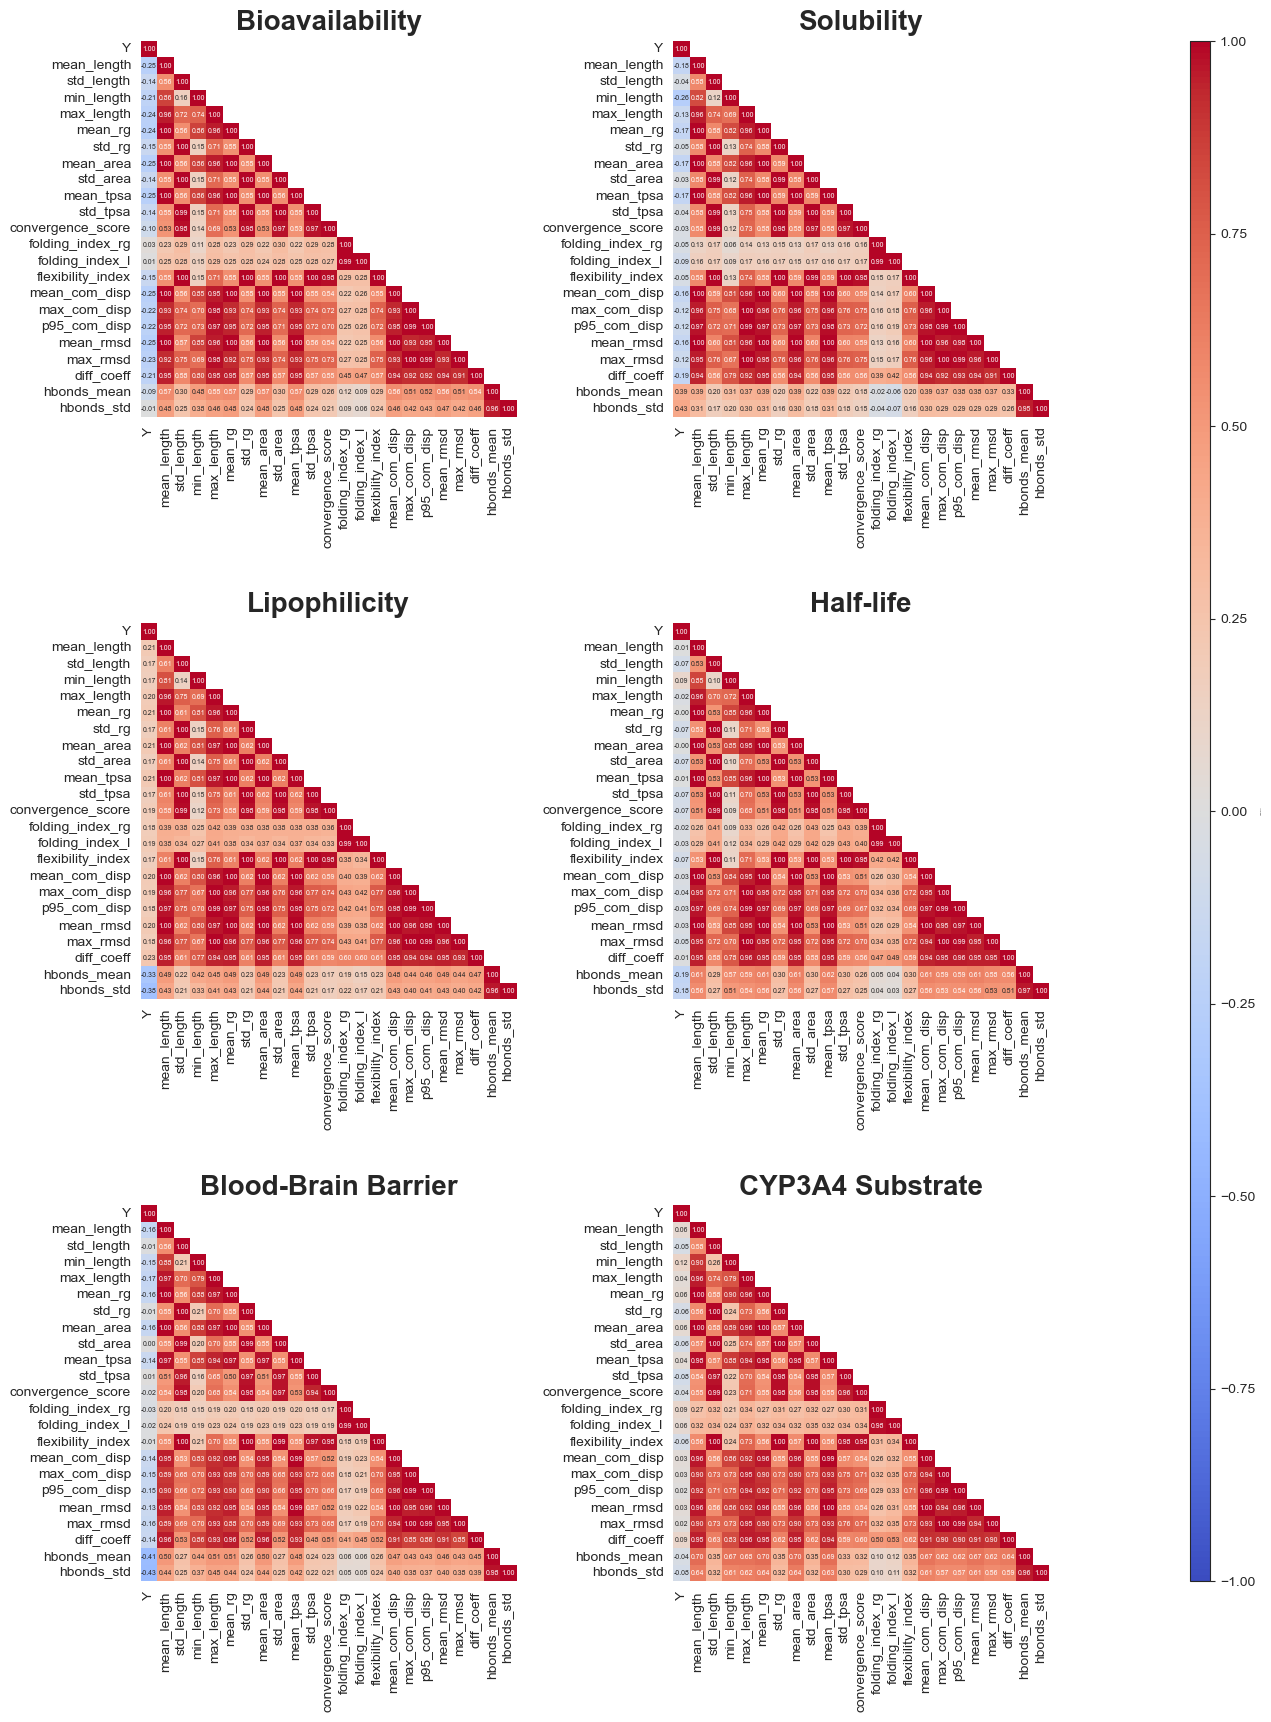

In [5]:
# Bigger A4-style portrait multi-heatmap (2 columns, stacked pairs)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# ---- inputs ----
CSV = "SMALLMOL_MD.csv"   # table must include 'dataset', 'Y', and MD columns

name_map = {
    "bioavailability_ma":       "Bioavailability",
    "solubility_aqsoldb":       "Solubility",
    "lipophilicity_astrazeneca":"Lipophilicity",
    "half_life_obach":          "Half-life",
    "bbb_martins":              "Blood-Brain Barrier",
    "cyp3a4_substrate_carbonmangels": "CYP3A4 Substrate"
}
DATASETS = list(name_map.keys())

MD_COLS = [
    'mean_length', 'std_length', 'min_length', 'max_length', 'mean_rg', 'std_rg', 'mean_area', 'std_area', 'mean_tpsa', 
    'std_tpsa', 'convergence_score', 'folding_index_rg', 'folding_index_l', 'flexibility_index', 'mean_com_disp', 
    'max_com_disp', 'p95_com_disp', 'mean_rmsd', 'max_rmsd', 'diff_coeff', "hbonds_mean", "hbonds_std"
]
TARGET = "Y"

# ---- load and keep numeric MD + Y ----
df = pd.read_csv(CSV)
have_md = [c for c in MD_COLS if c in df.columns]
keep_cols = ["dataset", TARGET] + have_md
df = df[keep_cols].copy()

def spearman_lower(df_xy, cols, include_y=True):
    cols = ([TARGET] if include_y and TARGET in df_xy.columns else []) + cols
    X = df_xy[cols].select_dtypes(include=[np.number])
    corr = X.corr(method="spearman")
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # upper triangle
    return corr.mask(mask)

# figure: portrait, larger so each heatmap is roomy
n = len(DATASETS)
ncols, nrows = 2, int(np.ceil(n / 2))
fig_h = 20.0                        # increase height for readability
fig_w = 14.0                        # modest width for portrait
fig = plt.figure(figsize=(fig_w, fig_h))
gs = GridSpec(nrows, ncols + 1, figure=fig, width_ratios=[1, 1, 0.05], wspace=0.45, hspace=0.55)

sns.set_style("white")
cmap = sns.color_palette("coolwarm", as_cmap=True)  # classic heatmap colours
vmin, vmax = -1.0, 1.0

axes = []
present = [ds for ds in DATASETS if (df["dataset"] == ds).any()]

for i, ds in enumerate(present):
    r, c = divmod(i, ncols)
    ax = fig.add_subplot(gs[r, c])
    axes.append(ax)

    dsub = df[df["dataset"] == ds].dropna(subset=[TARGET]).copy()
    corr = spearman_lower(dsub, have_md, include_y=True)

    sns.heatmap(
        corr, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, center=0,
        square=True, cbar=False, linewidths=0, linecolor="white",
        annot=True, fmt=".2f", annot_kws={"fontsize": 5}  # bigger numbers
    )
    ax.set_title(name_map.get(ds, ds), fontsize=20, pad=8, weight="bold")
    ax.tick_params(axis="x", labelrotation=90, labelsize=10)
    ax.tick_params(axis="y", labelsize=10)

# one shared colorbar on the right
cax = fig.add_subplot(gs[:, -1])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, cax=cax)
cb.set_label("Spearman ρ", fontsize=1)
cb.ax.tick_params(labelsize=10)


# optional saves
plt.savefig("MD_Spearman_per_dataset_big.png", dpi=300)
# plt.savefig("MD_Spearman_per_dataset_big.pdf")
plt.show()

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm

# Load SMILES file
df = pd.read_csv("SMALLMOL_SMILES_LIST.csv")
df.columns = [col.lower() for col in df.columns]
assert "smiles" in df.columns, "CSV must contain a 'smiles' column"
df["ID"] = df.get("compound_ID", df.index.astype(str))

# All RDKit descriptors excluding TPSA
descriptor_names = [desc[0] for desc in Descriptors.descList if desc[0] != "TPSA"]
descriptor_funcs = {name: getattr(Descriptors, name) for name in descriptor_names}

# Calculate descriptors
results = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    mol = Chem.MolFromSmiles(row["smiles"])
    if mol is None:
        continue
    desc_values = {desc: func(mol) for desc, func in descriptor_funcs.items()}
    desc_values["ID"] = row["ID"]
    desc_values["smiles"] = row["smiles"]
    results.append(desc_values)

# Save to DataFrame
df_rdkit = pd.DataFrame(results)
df_rdkit.to_csv("SMALLMOL_RDKit.csv", index=False)
print("✅ RDKit descriptors saved WITHOUT TPSA")

100%|████████████████████████████████████████| 247/247 [00:01<00:00, 194.48it/s]

✅ RDKit descriptors saved WITHOUT TPSA


In [17]:
import pandas as pd

# Load both datasets
df_md = pd.read_csv("SMALLMOL_MD.csv")
df_rdkit = pd.read_csv("SMALLMOL_RDKit.csv")

# Standardize ID type
df_md["ID"] = df_md["ID"].astype(str)
df_rdkit["ID"] = df_rdkit["ID"].astype(str)

# If RDKit also has a 'smiles' column, rename it to avoid duplication during merge
if "smiles" in df_rdkit.columns and "smiles" in df_md.columns:
    df_rdkit = df_rdkit.drop(columns=["smiles"])  # prefer MD's version

# Merge on ID
df_merged = pd.merge(df_md, df_rdkit, on="ID", how="left")

# Reorder columns: ID, smiles, Y at beginning, rest follow
identifier_cols = [col for col in ["ID", "smiles", "Y"] if col in df_merged.columns]
other_cols = [col for col in df_merged.columns if col not in identifier_cols]
df_merged = df_merged[identifier_cols + other_cols]

# Save result
df_merged.to_csv("SMALLMOL_MD_RDKit_ADMET.csv", index=False)
print("✅ Merged file saved as: SMALLMOL_MD_RDKit_ADMET.csv")

✅ Merged file saved as: SMALLMOL_MD_RDKit_ADMET.csv


In [19]:
print("🧮 Merged DataFrame shape:", df_merged.shape)

🧮 Merged DataFrame shape: (774, 242)


In [21]:
import pandas as pd
import numpy as np

def rdkit_spearman_fs(
    df, 
    meta_cols=('ID','smiles','dataset','Y'),
    md_cols=None,
    corr_thr=0.8, 
    min_var=1e-12
):
    df = df.copy()
    meta_cols = [c for c in meta_cols if c in df.columns]
    md_cols   = [c for c in (md_cols or []) if c in df.columns]

    # Identify RDKit features = numeric cols not in meta or MD
    forbidden = set(meta_cols) | set(md_cols)
    rdkit_cols = [c for c in df.columns if c not in forbidden]
    X_all = df[rdkit_cols].select_dtypes(include=[np.number])

    # --- 1) Drop zero/near-zero variance
    nunique = X_all.nunique(dropna=False)
    var = X_all.var(skipna=True, ddof=0)
    keep = (nunique > 1) & (var > min_var)
    X = X_all.loc[:, keep]

    # --- 2) Remove highly correlated features (Spearman)
    corr = X.corr(method="spearman").abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] >= corr_thr)]
    X_sel = X.drop(columns=to_drop)

    # --- Final DF = meta + MD + selected RDKit
    final_df = pd.concat([df[meta_cols], df[md_cols], X_sel], axis=1)

    summary = {
        "original_rdkit": len(X_all.columns),
        "after_lowvar": len(X.columns),
        "after_correlation": len(X_sel.columns),
        "dropped_due_to_corr": len(to_drop),
        "selected_rdkit": list(X_sel.columns),
    }

    # --- Pretty print ---
    print("\n=== RDKit Feature Selection Summary ===")
    print(f"Original RDKit features    : {summary['original_rdkit']}")
    print(f"After zero-var filter      : {summary['after_lowvar']}")
    print(f"After correlation pruning  : {summary['after_correlation']}")
    print(f"Dropped due to correlation : {summary['dropped_due_to_corr']}\n")

    print("Top 20 Selected RDKit Features:")
    for i, f in enumerate(summary["selected_rdkit"][:20], 1):
        print(f"  {i:2d}. {f}")

    return final_df, summary


# --- Example usage ---
df = pd.read_csv("SMALLMOL_MD_RDKit_ADMET.csv")

md_cols = [
    "mean_length", "std_length", "min_length", "max_length",
    "mean_rg", "std_rg",
    "mean_area", "std_area",
    "mean_tpsa", "std_tpsa",
    "convergence_score",
    "folding_index_rg", "folding_index_l",
    "flexibility_index",
    "mean_com_disp", "max_com_disp", "p95_com_disp",
    "mean_rmsd", "max_rmsd",
    "diff_coeff", "hbonds_mean", "hbonds_std"
]

final_df, summary = rdkit_spearman_fs(df, md_cols=md_cols, corr_thr=0.8)


=== RDKit Feature Selection Summary ===
Original RDKit features    : 216
After zero-var filter      : 193
After correlation pruning  : 129
Dropped due to correlation : 64

Top 20 Selected RDKit Features:
   1. MaxAbsEStateIndex
   2. MinAbsEStateIndex
   3. MinEStateIndex
   4. qed
   5. SPS
   6. MolWt
   7. MaxPartialCharge
   8. MinPartialCharge
   9. FpDensityMorgan1
  10. BCUT2D_MWHI
  11. BCUT2D_MWLOW
  12. BCUT2D_MRHI
  13. BCUT2D_MRLOW
  14. AvgIpc
  15. BalabanJ
  16. HallKierAlpha
  17. PEOE_VSA1
  18. PEOE_VSA10
  19. PEOE_VSA11
  20. PEOE_VSA12


In [23]:
# Step 1: Define preferred column order
ordered_cols = ['ID', 'smiles', 'dataset', 'Y']
remaining_cols = [col for col in final_df.columns if col not in ordered_cols]
final_ordered_df = final_df[ordered_cols + remaining_cols]

# Step 2: Save to CSV
final_ordered_df.to_csv("MD_ADMET_RDKIT_FS.csv", index=False)

print("✅ File saved as 'MD_ADMET_RDKIT_FS.csv' with proper column order.")

✅ File saved as 'MD_ADMET_RDKIT_FS.csv' with proper column order.


In [25]:
import pandas as pd

# Load the full merged dataset
df = pd.read_csv("MD_ADMET_RDKIT_FS.csv")

# Count molecules per dataset
dataset_counts = df["dataset"].value_counts()

total_ids = df["ID"].nunique()

# Display results
print(f"📊 Total unique IDs in dataset: {total_ids}")
print("📊 Dataset Sizes:")
print(dataset_counts)

📊 Total unique IDs in dataset: 233
📊 Dataset Sizes:
dataset
cyp3a4_substrate_carbonmangels    173
bioavailability_ma                149
half_life_obach                   128
bbb_martins                       122
lipophilicity_astrazeneca         105
solubility_aqsoldb                 97
Name: count, dtype: int64
